# Lasso inpainting

In [1]:
from code import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
from sklearn import linear_model
import copy
import random
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC

In [2]:
def read_im(fn):
    rgb = plt.imread(fn)
    if rgb.dtype == np.uint8:
        rgb = rgb/255
    #hsv = clrs.rgb_to_hsv(rgb)
    #norm = 2*hsv - 1
    return rgb

def show_im(image):
    #hsv = (image+1) /2
    #rgb = clrs.hsv_to_rgb(hsv)
    plt.imshow(image)
    plt.show()

In [3]:
def get_patch(i,j,h,im):
    """
    h impair
    """
    d = h//2
    if (i-d >= 0 and i+d <= im.shape[0] and j-d>=0 and j+d <= im.shape[1]):
        return im[i-d:i+d+1,j-d:j+d+1,:]

In [4]:
def patch2vect(patch):
    return patch.reshape(-1,1)

def vect2patch(vect):
    h = int(np.sqrt((len(vect)/3)))
    return vect.reshape(h,h,3)

In [5]:
def noise(img,prc):
    new = copy.deepcopy(img)
    pos = [(i,j) for j in range (img.shape[1]) for i in range(img.shape[0])]
    np.random.shuffle(pos)
    nb = int(len(pos)*prc)
    bruit = pos[:nb]
    for (i,j) in bruit:
        new[i,j] = [-100., -100., -100.]
    return new

def delete_rect(img, i, j, height, width):
    new = copy.deepcopy(img)
    new[i:i+height, j:j+width] = np.ones((height,width,3))*(-100.)
    return new

In [6]:
def patchs(img, h):
    patchBruit = []
    patchSansBruit = []
    patchBruitPos = []
    for i in range(h//2,img.shape[0]-h//2, h):
        for j in range(h//2,img.shape[1]-h//2, h):
            patch = get_patch(i,j,h,img)
            vect = patch2vect(patch)
            if np.any(vect == -100.):
                patchBruit.append(patch)
                patchBruitPos.append((i,j))
            else :
                patchSansBruit.append(patch)
    return patchBruit, patchSansBruit, patchBruitPos

In [11]:
def debruiter(patchbruite,dictionnaire):
    clf = Lineaire(loss_g = lambda x,y,w : lasso_g(x,y,w,0.1), eps=0.001)
    datay = patch2vect(patchbruite)
    nip = datay!=-100.
    datay = datay[nip]
    if len(datay)==0:
        return None
    datax = np.array([patch2vect(patch)[nip] for patch in dictionnaire]).T
    clf.fit(datax, datay)
    return clf

def debruitersklearn(patchbruite,dictionnaire,alpha=0.0001,max_iter=1000):
    clf = linear_model.Lasso(alpha=alpha,max_iter = max_iter)
    datay = patch2vect(patchbruite)
    nip = datay!=-100.
    datay = datay[nip]
    if len(datay)==0:
        #print("datay null 1")
        return None
    datax = np.array([patch2vect(patch)[nip] for patch in dictionnaire]).T
    clf.fit(datax, datay)
    return clf

In [8]:
def debruiter_image(img_bruite, h):
    #création des dictionnaires et des patchs
    b,sb,posb = patchs(img_bruite, h)
    print(len(b),len(sb))
    
    datax = np.array([patch2vect(patch) for patch in sb]).T[0]
    
    #prédiction des patchs bruités
    patchpredict = []
    for patchb in b :
        #print(patchb)
        clf = debruitersklearn(patchb, sb)
        if clf == None:
            #print("datay null 2")
            patchpredict.append(patchb)
        else:
            vectpredict = clf.predict(datax)
            patchpredict.append(vect2patch(vectpredict))
    
    #reconstruction de l'image débruitée en collant les patchs
    final = []
    a2 = 0
    b2 = 0
    for i in range(h//2,img_bruite.shape[0]-h//2, h):
        for j in range(h//2,img_bruite.shape[1]-h//2, h):
            if (i,j) in posb:
                final.append(patchpredict[a2])
                a2 += 1
            else:
                final.append(sb[b2])
                b2 += 1
    final = np.array(final)

    res = final.reshape((-1, int(img_bruite.shape[1]/h),h,h,3))
    res2=[]
    for i in range(int(img_bruite.shape[0]/h)):
        res2.append(np.hstack(res[i,:]))

    #show_im(img_bruite)
    show_im(np.vstack(res2))
    return np.vstack(res2)

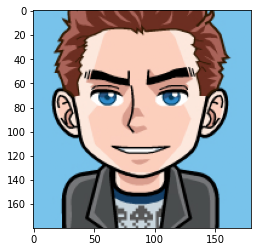

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


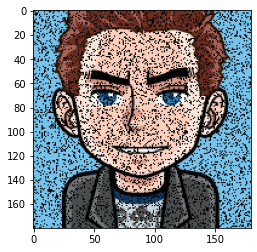

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


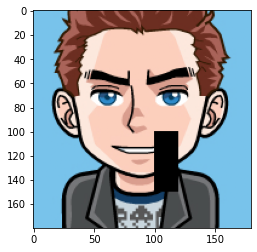

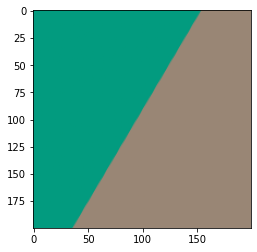

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


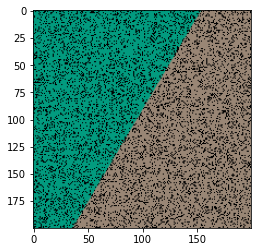

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


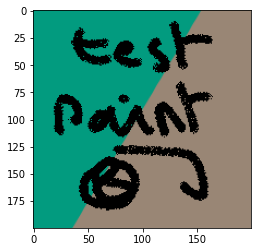

In [9]:
img1 = read_im("image.png")
img2 = noise(img1, 0.20)
img3 = delete_rect(img1, 100, 100, 50, 20)
img4 = read_im("test1.png")
img5 = noise(img4, 0.20)
#j'ai mis du noir en amout, je remplace donc les 0 par des -100
img6 = read_im("test2.png")
img6 = img6[:,:,:3]
img6 = np.where(img6==0., -100., img6)

show_im(img1)
show_im(img2)
show_im(img3)
show_im(img4)
show_im(img5)
show_im(img6)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


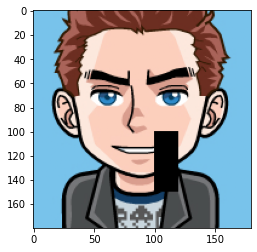

119 3481


c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5761561118997633e-05, tolerance: 1.661411988607142e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.39249090757221e-05, tolerance: 9.968472113541793e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.39249090757221e-05, tolerance: 9.968472113541793e-06
  model = cd_fa

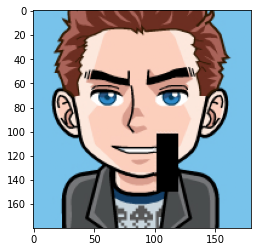

40 1256


c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.95303494669497e-05, tolerance: 4.694458402809687e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.969462265260518e-05, tolerance: 2.469230821589008e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.529905997216702e-05, tolerance: 2.4910819774959236e-05
  model = cd_f

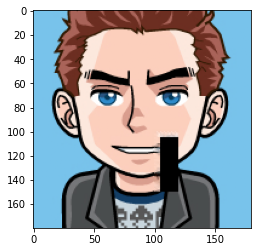

21 604


c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014527328312397003, tolerance: 0.00010201756958849728
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2576418966054916e-05, tolerance: 3.727923467522487e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.022006917744874954, tolerance: 0.002019297331571579
  model = cd_

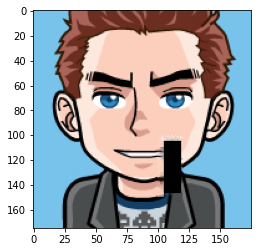

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.005696523934602737, tolerance: 0.0008348150877282023
  model = cd_fast.enet_coordinate_descent(


18 343


c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.025142863392829895, tolerance: 0.002978250151500106
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.011255413293838501, tolerance: 0.002446382539346814
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0018958821892738342, tolerance: 0.0006658875499852002
  model = cd_fast.

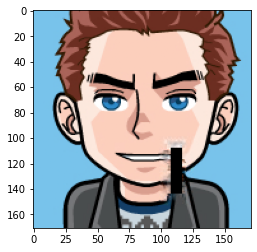

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10971900820732117, tolerance: 0.0015926474006846547
  model = cd_fast.enet_coordinate_descent(


10 215


c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00228707492351532, tolerance: 0.0004452963767107576
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0581626296043396, tolerance: 0.002710238564759493
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01977097988128662, tolerance: 0.003764035413041711
  model = cd_fast.enet_

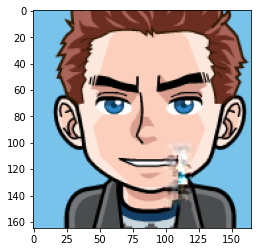

In [12]:
show_im(img3)

v = 3
tmp = debruiter_image(img3, v)

while -100. in tmp:
    v += 2
    tmp = debruiter_image(tmp, v)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


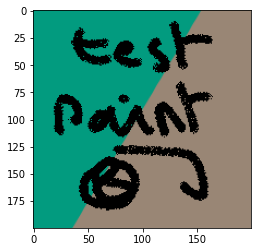

In [13]:
show_im(img6)

141 183


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


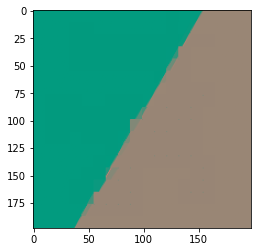

In [143]:
tmp = debruiter_image(img6, 11)

3150 450


c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006880909204483032, tolerance: 0.00017325540829915553
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00032712850952520967, tolerance: 6.304030102910474e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.81986488820985e-05, tolerance: 5.4095828090794384e-05
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0007266300381161273, tolerance: 9.03605468920432e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.0698483139276505e-05, tolerance: 5.726659219362773e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.939964805496857e-05, tolerance: 2.404036968073342e-05
  model = cd_f

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.957023965194821e-05, tolerance: 4.708590859081596e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.06139869382605e-05, tolerance: 2.9903798349550925e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.881845623254776e-05, tolerance: 2.792712075461168e-05
  model = cd_f

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.353565888479352e-05, tolerance: 5.8961682952940464e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.01492715254426e-05, tolerance: 4.426957093528472e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.479000487364829e-05, tolerance: 5.810659422422759e-05
  model = cd_f

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00021709955763071775, tolerance: 0.0001680685527389869
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.889622166752815e-05, tolerance: 3.436494807829149e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.1176372431218624e-05, tolerance: 3.07281079585664e-05
  model = cd_

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010584302071947604, tolerance: 6.138229218777269e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.353645585477352e-05, tolerance: 3.151593773509376e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.517155033070594e-05, tolerance: 8.72382315719733e-06
  model = cd_f

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000566249480471015, tolerance: 0.00025512930005788803
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001378228480461985, tolerance: 5.5093096307246014e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.101834100671113e-05, tolerance: 4.272451042197645e-05
  model = cd_

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.2656978368759155e-05, tolerance: 2.9021071895840578e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010136868513654917, tolerance: 4.292469020583667e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00014612218365073204, tolerance: 5.6942139053717256e-05
  model =

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.5902962079271674e-05, tolerance: 2.5800778530538082e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00037305656587705016, tolerance: 0.00011851586896227673
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011410891311243176, tolerance: 0.00026468050782568753
  model =

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.501113577745855e-05, tolerance: 5.3616044169757515e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026101822732016444, tolerance: 0.00017230602679774165
  model = cd_fast.enet_coordinate_descent(
c:\u

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011017239885404706, tolerance: 0.0003541432088240981
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004658468533307314, tolerance: 0.00018208016990683973
  model = cd_fast.enet_coordinate_descent(
c:\use

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00044774613343179226, tolerance: 0.00011648381769191474
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0012128795497119427, tolerance: 0.00020345654047559947
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001124558039009571, tolerance: 0.0001786611246643588
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00047575728967785835, tolerance: 0.0002228267549071461
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.969920261530206e-06, tolerance: 5.5439472816942725e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00035155145451426506, tolerance: 0.000321913103107363
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022944825468584895, tolerance: 0.00011003844701917842
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009455696563236415, tolerance: 0.00035428671981208026
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001338267931714654, tolerance: 0.00027759314980357885
  model = c

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006037847488187253, tolerance: 0.00017330949776805937
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0009544882923364639, tolerance: 0.00029702699976041913
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0016017132438719273, tolerance: 0.0002543073205742985
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00022105587413534522, tolerance: 9.57400188781321e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00031632877653464675, tolerance: 8.700181933818385e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002237892767880112, tolerance: 8.964614244177938e-05
  model = cd_

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.4173149187117815e-06, tolerance: 6.554145329573657e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.095881013199687e-05, tolerance: 1.3893554751120973e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001768303627613932, tolerance: 6.639130151597783e-05
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.05205287784338e-05, tolerance: 1.2100728781661019e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.660829967586324e-06, tolerance: 6.193514309416059e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.778624421916902e-06, tolerance: 6.3615907492931e-06
  model = cd_fas

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002716406888794154, tolerance: 0.00020829572167713195
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00025513910804875195, tolerance: 0.0001303231983911246
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.6294001145288348e-05, tolerance: 2.0401819710968994e-05
  model = 

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.000885798130184412, tolerance: 0.0003176962782163173
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003969903336837888, tolerance: 0.00012779129610862583
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0010846793884411454, tolerance: 0.00014158833073452115
  model = cd_

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.621318218298256e-06, tolerance: 5.62333116249647e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003491116804070771, tolerance: 0.0001552848843857646
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00034955135197378695, tolerance: 0.00010719096462707967
  model = cd_

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.41019141767174e-06, tolerance: 4.817035460291663e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0004072573210578412, tolerance: 0.00038526253774762154
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.001074278843589127, tolerance: 0.0002727227401919663
  model = cd_fa

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.2276970664970577e-05, tolerance: 7.361014013440581e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003355524386279285, tolerance: 6.0818045312771574e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00010321712034055963, tolerance: 7.724994065938517e-05
  model = c

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.598336479626596e-05, tolerance: 2.5543760784785263e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006990751717239618, tolerance: 0.00012532556138467044
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00026070355670526624, tolerance: 9.591886191628873e-05
  model = c

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.820959581295028e-06, tolerance: 5.6549670262029395e-06
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4891429347917438e-05, tolerance: 2.4590475732111372e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.05049023963511e-06, tolerance: 4.727070063381689e-06
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0019001939799636602, tolerance: 0.00030467240139842033
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0002732125576585531, tolerance: 0.00019514588348101825
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.4485838366672397e-05, tolerance: 2.0356270397314802e-05
  model = 

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0006037997081875801, tolerance: 0.00024715514155104756
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.454002090729773e-05, tolerance: 7.117714994819835e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0017018545186147094, tolerance: 0.00021708128042519093
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.1778519516810775e-05, tolerance: 3.987228046753444e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.597516868263483e-07, tolerance: 1.762783199410478e-07
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00013433070853352547, tolerance: 4.418812750373036e-05
  model = cd

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00017622957238927484, tolerance: 6.281337846303359e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.34531398746185e-07, tolerance: 1.573021108924877e-07
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.863081706687808e-07, tolerance: 1.5466576996914227e-07
  model = cd_

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9519211491569877e-07, tolerance: 1.8089194497861172e-07
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7438287613913417e-07, tolerance: 1.573021108924877e-07
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00018198636826127768, tolerance: 3.633166488725692e-05
  model = 

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.334218076313846e-05, tolerance: 2.5694118448882364e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.00040268973680213094, tolerance: 0.00013907410902902484
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0001388944947393611, tolerance: 7.556141645181924e-05
  model = c

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0003115831932518631, tolerance: 8.97508580237627e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.542182432487607e-05, tolerance: 3.4447264624759555e-05
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
c:\user

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.3080716598778963e-07, tolerance: 1.0705282704748242e-07
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.9418879421427846e-07, tolerance: 1.1858684700882804e-07
  model = cd_fast.enet_coordinate_descent(
c:\

c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.9538128981366754e-07, tolerance: 1.2345677191660798e-07
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.2791937226429582e-07, tolerance: 1.0852966880747772e-07
  model = cd_fast.enet_coordinate_descent(
c:\users\antoine cadiou\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:474: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.246306394226849e-07, tolerance: 1.3014224009566533e-07
  model =

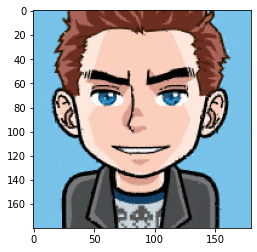

In [14]:
tmp = debruiter_image(img2, 3)

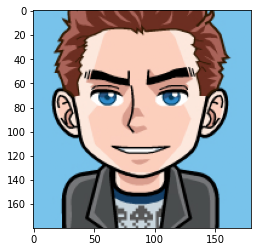

In [155]:
show_im(img1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


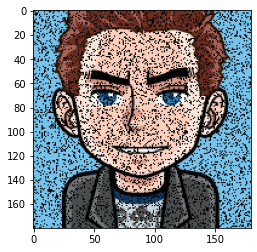

In [15]:
show_im(img2)